# Analysis of local search behavior after reward in single-object forest
### For experiments with multiple conditions tested (not in single fly). First part of notebook to copare acorss flies within single condition (e.g. with or without LMs), second part to compare across conditions.
* Assumes use of FlyOver version 1.0.7 or higher (closed-loop optogenetic stimulation *with reset radius*)
* Data from multiple trials and flies is pooled and collected in a single data frame, which is then used for data visualisation and statistics.

In [35]:
import numpy as np
from os.path import sep
from os import getcwd, mkdir
from sys import path
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import rcParams

from scipy import stats as sts

import pandas as pd

from Tkinter import Tk
from tkFileDialog import askdirectory

# Set path to analysis code directory
codeDir = sep.join(getcwd().split(sep)[:-2])
path.insert(1, codeDir)

from plottingUtilities.basicPlotting import myAxisTheme,_myAccentList
from plottingUtilities.objectPreferencePlots import countvisits
from trajectoryAnalysis.circularStatsOnTrajectories import circmeanvec

In [36]:
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

%matplotlib inline

In [37]:
# Choose files to analyse ..............................................................................................

baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObjOpt/localSearch/'

root = Tk()
# prevents root window from appearing
root.withdraw()
# choose experiment folder
summaryDir = askdirectory(initialdir=baseDir,
                       title='Select experiment directory (containing directories for multiple flies)') + sep
root.update()
root.destroy()

## Generate combined plot across groups (need to run analysis for each group first)

In [38]:
genotype = summaryDir.split(sep)[-5]
protocol = summaryDir.split(sep)[-2]
print(genotype)
print(protocol)

hexGridSize = int(summaryDir.split(sep)[-4][:2])*10
print(hexGridSize)

Gr64f_x_10xChrimsonR_f
analysis
120


In [39]:
try:
    mkdir(summaryDir + 'summary')
except:
    print('Plot directory already exists')
    
    
sampleSizes = [5,5] #[20,20,20]#[3,12,11]#
expNames = ['visLM', 'noLM'] #'onlyLM',
expCols = ['palevioletred', 'grey'] #'teal', 

fps = 20

### Velocity response

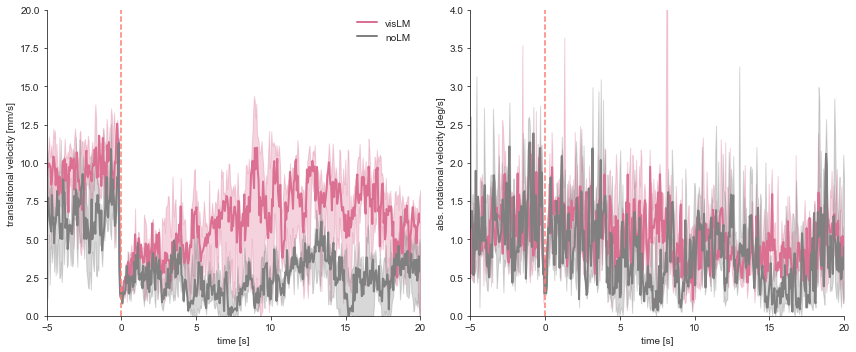

In [53]:
tmax = 20
tmin = -5
window = int(fps*tmax)
prewindow = int(fps*-tmin)
timeax = np.linspace(tmin,tmax, window+prewindow)
datdir = summaryDir+ 'reinforcementEffect'+sep

fig, axs = plt.subplots(1,2,figsize=(12,5))

for k, expName in enumerate(expNames):
    n = sampleSizes[k]
    expfileVR = '{}_{}_trigRotVelo_medianIQRAcrossFlies_{}s_n{}.npy'.format(genotype, expName,tmax,n)
    expdatVR = np.load(datdir+expfileVR)
    expfileVT = '{}_{}_trigTransVelo_medianIQRAcrossFlies_{}s_n{}.npy'.format(genotype, expName,tmax,n)
    expdatVT = np.load(datdir+expfileVT)
    
    [qt25, qt50, qt75] = np.nanpercentile(expdatVT,[25,50,75],axis=0)
    axs[0].plot(timeax,qt50, color=expCols[k], linewidth=2, label=expName)
    axs[0].fill_between(timeax,qt25, qt75, color=expCols[k],linewidth=1,alpha=0.3)

    [qt25, qt50, qt75] = np.nanpercentile(expdatVR,[25,50,75],axis=0)
    axs[1].plot(timeax,qt50, color=expCols[k], linewidth=2)
    axs[1].fill_between(timeax,qt25, qt75, color=expCols[k], linewidth=1,alpha=0.3)

for ax in axs:
    myAxisTheme(ax)
    ax.legend(frameon=False)
    ax.set_xlabel('time [s]')
    ax.axvline(0,0,1,color='salmon', linestyle='dashed', linewidth=1.5)
    ax.set_xlim(tmin, tmax)
axs[0].set_ylim(0,20)
axs[1].set_ylim(0,4)
axs[0].set_ylabel('translational velocity [mm/s]')
axs[1].set_ylabel('abs. rotational velocity [deg/s]')

fig.tight_layout()

if len(sampleSizes) == 2:
    fig.savefig(summaryDir + 'summary/'+genotype + '_velocityResponse_allgroups_'+str(tmax)+'s_n{}-{}.pdf'.format(sampleSizes[0],sampleSizes[1]), format='pdf')
else:
    fig.savefig(summaryDir + 'summary/'+genotype + '_velocityResponse_allgroups_'+str(tmax)+'s_n{}-{}-{}.pdf'.format(sampleSizes[0],sampleSizes[1],sampleSizes[2]), format='pdf')

### Distance moved

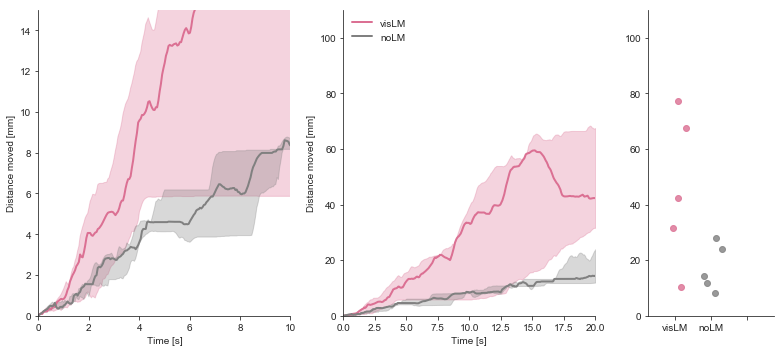

In [54]:
datdir = summaryDir+ '/distanceMoved'+sep

windowMax = 20

tmax = [10, windowMax]
ymax = [15, 110]
fig, ax = plt.subplots(1,3, figsize=(11,5), gridspec_kw={'width_ratios':[2,2,1]})
window = int(fps*windowMax)
timeax = np.linspace(0,windowMax, window)

nsize = []

for k, expName in enumerate(expNames):
    n = sampleSizes[k]
    expfile = '{}_{}_distAfterRewardMedianFly_{}s_n{}.npy'.format(genotype,expName,windowMax,n)
    expdat = np.load(datdir+expfile)
    
    nsize.append(len(expdat))
    # Plot data
    for i in range(2):
        [qt25, qt50, qt75] = np.nanpercentile(expdat,[25,50,75],axis=0)
        
        ax[i].plot(timeax,qt50, color=expCols[k], linewidth=2, label=expNames[k])
        ax[i].fill_between(timeax,qt25, qt75, color=expCols[k], linewidth=1,alpha=0.3)
         
    evtime = windowMax
    binrange = (0,ymax[1])
    histdat = expdat[:,int(evtime*fps)-1]
    ax[2].plot(k*np.ones(len(histdat))+0.75+np.random.rand(len(histdat))*.55, histdat, 'o', color=expCols[k], alpha=0.8)
    
    
for i in range(2):
    ax[i].set_xlim(0,tmax[i])
    ax[i].set_ylim(0,ymax[i])
    ax[i].set_xlabel('Time [s]')
    ax[i].set_ylabel('Distance moved [mm]')
ax[1].legend(loc=2, frameon=False)
        
ax[2].set_xlim(0.25,3.75)
plt.xticks(np.arange(3)+1, expNames)
ax[2].set_ylim(binrange)

[myAxisTheme(axi) for axi in ax]
fig.tight_layout()

if len(sampleSizes) == 2:
    fig.savefig(summaryDir + 'summary/'+genotype +'_distAfterReward_allgroups_'+
                str(windowMax)+'s_n{}-{}.pdf'.format(sampleSizes[0],sampleSizes[1]), format='pdf')
else:
    fig.savefig(summaryDir + 'summary/'+genotype +'_distAfterReward_allgroups_'+
                str(windowMax)+'s_n{}-{}-{}.pdf'.format(sampleSizes[0],sampleSizes[1],sampleSizes[2]), format='pdf')

### Curvyness

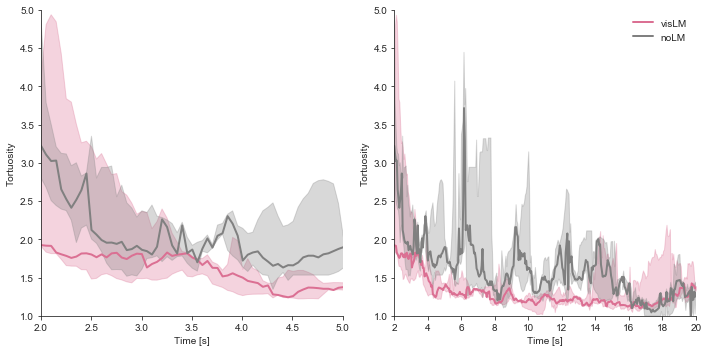

In [55]:
windowMax = 20
slidWind = int(2*fps)

tmax = [5, windowMax]
fig, ax = plt.subplots(1,2, figsize=(10,5), gridspec_kw={'width_ratios':[2,2]})
window = int(fps*windowMax)
timeax = np.linspace(slidWind/fps,windowMax, window-slidWind)

for k, expName in enumerate(expNames):
    n = sampleSizes[k]
    expfile = '{}_{}_tortuosityPostRewardMedianFly_window{}s_{}s_n{}.npy'.format(genotype,expName,int(slidWind/fps),windowMax,n)
    expdat = np.load(summaryDir+ 'curvyness'+sep+expfile)
    
    # Plot data
    for i in range(2):
        [qt25, qt50, qt75] = np.nanpercentile(expdat,[25,50,75],axis=0)
        
        ax[i].plot(timeax,qt50, color=expCols[k], linewidth=2, label=expNames[k])
        ax[i].fill_between(timeax,qt25, qt75, color=expCols[k], linewidth=1,alpha=0.3)

for i in range(2):
    ax[i].set_xlim(int(slidWind/fps),tmax[i])
    ax[i].set_ylim(1,5)
    ax[i].set_xlabel('Time [s]')
    ax[i].set_ylabel('Tortuosity')
ax[1].legend(loc=1, frameon=False)


[myAxisTheme(axi) for axi in ax]
fig.tight_layout()
if len(sampleSizes) == 2:
    fig.savefig(summaryDir + 'summary/'+genotype+'_tortuosityAfterReward_allgroups_window'
            +str(int(slidWind/fps))+'s_'+str(windowMax)+'s_n{}-{}.pdf'.format(sampleSizes[0],sampleSizes[1]), format='pdf')
else:
    fig.savefig(summaryDir + 'summary/'+genotype+'_tortuosityAfterReward_allgroups_window'
            +str(int(slidWind/fps))+'s_'+str(windowMax)+'s_n{}-{}-{}.pdf'.format(sampleSizes[0],sampleSizes[1],sampleSizes[2]), format='pdf')

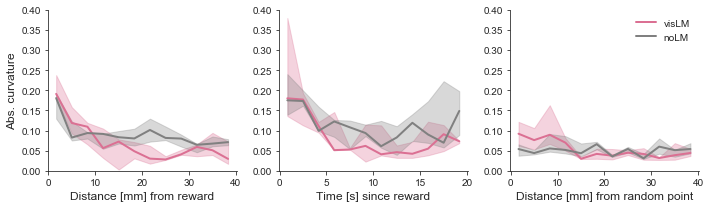

In [56]:
windowMax = 20
pathLength = 40

tmax = [5, windowMax]
fig, axs = plt.subplots(1,3,figsize=(10,3))
window = int(fps*windowMax)
timeax = np.linspace(0,windowMax, window)
nsize = []

for k, expName in enumerate(expNames):
    n = sampleSizes[k]
    expfile = '{}_{}_curvatureAverRewardDat_medianperFlyAndAcross_pl{}mm_t{}s_n{}.npy'.format(genotype,expName,pathLength,windowMax,n)
    expdat = np.load(summaryDir+ '/curvyness'+sep+expfile)
    expfileX = '{}_{}_curvatureAverRewardBinLocs_medianperFlyAndAcross_pl{}mm_t{}s_n{}.npy'.format(genotype,expName,pathLength,windowMax,n)
    expdatX = np.load(summaryDir+ '/curvyness'+sep+expfileX)
    
    # Plot data
    for i in range(3):
        [qt25, qt50, qt75] = np.nanpercentile(expdat[i],[25,50,75],axis=0)
        axs[i].plot(expdatX[i],qt50, linewidth=2,color=expCols[k], label=expNames[k])
        axs[i].fill_between(expdatX[i],qt25, qt75, color=expCols[k], linewidth=1,alpha=0.3)

for ax in axs:
    myAxisTheme(ax)
    ax.set_ylim(0,0.4)
axs[0].set_ylabel('Abs. curvature', fontsize=12)
axs[0].set_xlabel('Distance [mm] from reward', fontsize=12)
axs[1].set_xlabel('Time [s] since reward', fontsize=12)
axs[2].set_xlabel('Distance [mm] from random point', fontsize=12)
axs[2].legend(loc=1, frameon=False)

fig.tight_layout()
if len(sampleSizes) == 2:
    fig.savefig(summaryDir + 'summary/'+genotype +'_curvatureAfterReward-Time-Path_allgroups_'
                +str(windowMax)+'s_n{}-{}.pdf'.format(sampleSizes[0],sampleSizes[1]), format='pdf')
else:
    fig.savefig(summaryDir + 'summary/'+genotype +'_curvatureAfterReward-Time-Path_allgroups_'
                +str(windowMax)+'s_n{}-{}-{}.pdf'.format(sampleSizes[0],sampleSizes[1],sampleSizes[2]), format='pdf')

### Turns

In [58]:
def stylePolarPlot(titlestr,ax,ytickvals):
    ax.set_xticklabels(['0','', r'$\frac{\pi}{2}$','', r'$\pi,-\pi$','', r'$-\frac{\pi}{2}$',''],fontsize=12)
    ax.set_title(titlestr)
    ax.set_rlabel_position(225)
    ax.set_xlim(0, 2*np.pi)
    ax.set_yticks(ytickvals)
    ax.set_theta_zero_location("N")
    #ax.spines['polar'].set_visible(False)

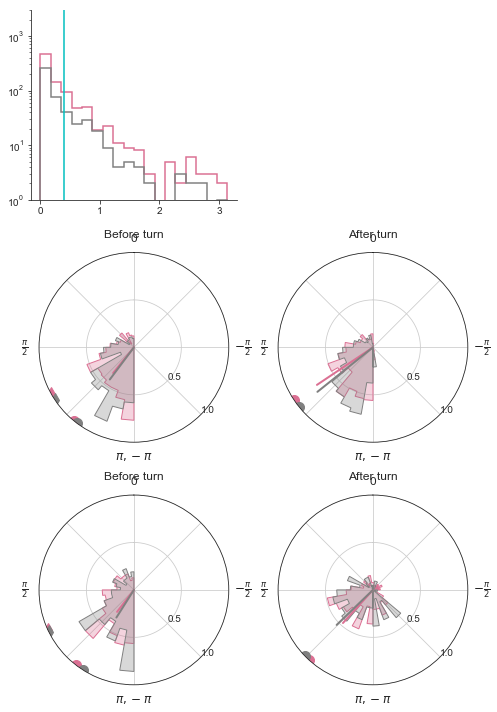

In [61]:
windowMax = 20
minObjDist = 6

keylistTurnsdf = ['flyID','turnSize','turnAngleSt','turnAngleEd','turnLengthT','turnLengthP','turnStObjDist'] 

nbins=36
rangebins = (-np.pi, np.pi)
ytickvals = [.5, 1]
turnsizecut = np.pi/8
turnSizeRanges = [(0,turnsizecut),(turnsizecut,np.pi)]

fig= plt.figure(figsize=(7, 3+3.5*len(turnSizeRanges)))
maxY = 1
ax1 = fig.add_subplot(len(turnSizeRanges)+1,2,1)

for k, expName in enumerate(expNames):
    n = sampleSizes[k]
    expfile = '{}_{}_relHeadingBeforeAfter_pooledOverFliesAndPaths_wind{}s_n{}.npy'.format(genotype, expName,windowMax,n)
    expdat = np.load(sep.join([summaryDir,'PIanalysis',expfile]))
    expdatdf = pd.DataFrame(expdat, columns=keylistTurnsdf)
    #turn size distribution:
    turns = expdatdf['turnSize'].values.astype('float')
    ax1.hist(turns,bins=18, range=(0,np.pi), histtype='step',edgecolor=expCols[k],linewidth=1.5)
ax1.axvline(turnsizecut,0,1,color='c')
ax1.set_ylim(1, 3000)
ax1.set_yscale("log")
myAxisTheme(ax1)

for i, tsRange in enumerate(turnSizeRanges):
    ax2 = fig.add_subplot(len(turnSizeRanges)+1,2,2*i+3, projection='polar')
    ax3 = fig.add_subplot(len(turnSizeRanges)+1,2,2*i+4, projection='polar')

    for k, expName in enumerate(expNames):
        n = sampleSizes[k]
        expfile = '{}_{}_relHeadingBeforeAfter_pooledOverFliesAndPaths_wind{}s_n{}.npy'.format(genotype,expName,windowMax,n)
        expdat = np.load(sep.join([summaryDir,'PIanalysis',expfile]))
        expdatdf = pd.DataFrame(expdat, columns=keylistTurnsdf)
    
        minSizeDf = expdatdf.query('turnSize >= {} and turnSize < {} and turnStObjDist > {}'.format(tsRange[0],tsRange[1],minObjDist))
        turnsHeadings = np.zeros((2,len(minSizeDf['turnAngleSt'].values)))

        turnsHeadings[0,:] = minSizeDf['turnAngleSt'].values.astype('float')
        turnsHeadings[1,:] = minSizeDf['turnAngleEd'].values.astype('float')

        goalPos = np.sign(turnsHeadings[0,:])
        turnsHeadings[0,:][goalPos<0] = -1*turnsHeadings[0,:][goalPos<0]
        turnsHeadings[1,:][goalPos<0] = -1*turnsHeadings[1,:][goalPos<0]
        
        ax2.hist(turnsHeadings[0,:] ,bins=nbins, range=rangebins, histtype='stepfilled',color=expCols[k],density=True, alpha=0.3)
        ax2.hist(turnsHeadings[0,:] ,bins=nbins, range=rangebins, histtype='step',color=expCols[k],density=True)
        stylePolarPlot('Before turn',ax2,ytickvals)
        meandir, meanlen = circmeanvec(turnsHeadings[0,:], np.ones(len(turnsHeadings[0,:])), high=np.pi, low=0)
        ax2.plot([0,meandir], [0,meanlen],'-', color=expCols[k],linewidth=2)
        ax2.plot(meandir, maxY,'o',color=expCols[k],markersize=10)
        ax2.plot(np.mean(turnsHeadings[0,:],0), maxY,'d',color=expCols[k],markersize=10)
        ax2.set_ylim(0,maxY)
        
        ax3.hist(turnsHeadings[1,:],bins=nbins, range=rangebins,histtype='stepfilled',color=expCols[k],density=True, alpha=0.3)
        ax3.hist(turnsHeadings[1,:],bins=nbins, range=rangebins,histtype='step',color=expCols[k],density=True)
        stylePolarPlot('After turn',ax3,ytickvals)
        meandir, meanlen = circmeanvec(turnsHeadings[1,:], np.ones(len(turnsHeadings[1,:])), high=np.pi, low=-np.pi)
        ax3.plot([0,meandir], [0,meanlen],'-',color=expCols[k],linewidth=2)
        ax3.plot(meandir, maxY,'o',color=expCols[k],markersize=10)
        ax3.set_ylim(0,maxY)

fig.tight_layout()
if len(sampleSizes) == 2:
    fig.savefig(summaryDir + 'summary/'+genotype +'_relHeadingBeforeAfter_allgroups_'+
            str(windowMax)+'s_n{}-{}.pdf'.format(sampleSizes[0],sampleSizes[1]), format='pdf')
else:
    fig.savefig(summaryDir + 'summary/'+genotype +'_relHeadingBeforeAfter_allgroups_'+
                str(windowMax)+'s_n{}-{}-{}.pdf'.format(sampleSizes[0],sampleSizes[1],sampleSizes[2]), format='pdf')

### Runs

IOError: [Errno 2] No such file or directory: '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObjOpt/localSearch/Gr64f_x_10xChrimsonR_f/12cmHex/0h/analysis//PIanalysis/Gr64f_x_10xChrimsonR_f_noLM_pathLengthVsDistanceMedCI_pooledOverFliesAndPaths_wind20s_n5.npy'

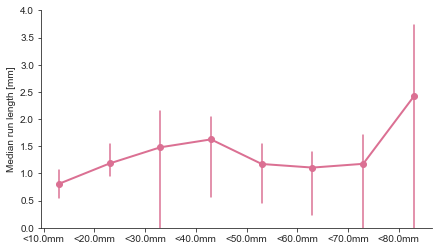

In [62]:
distBins = np.linspace(0,80,9)
fig, axs = plt.subplots(1,1,figsize=(7,4))
offsets = [3,1.5,0]
for k, expName in enumerate(expNames):
    n = sampleSizes[k]
    os = offsets[k] # plotting offset
    expfile = '{}_{}_pathLengthVsDistanceMedCI_pooledOverFliesAndPaths_wind{}s_n{}.npy'.format(genotype,expName,windowMax,n)
    expdat = np.load(sep.join([summaryDir,'PIanalysis',expfile]))
    for i, db in enumerate(distBins[1:]):
        axs.plot([db+os,db+os], [expdat[i,1],expdat[i,2]],'-',color=expCols[k])
    axs.plot(distBins[1:]+os, expdat[:,0],'o-',linewidth=2,color=expCols[k])
    xinds = distBins[1:]
    plt.xticks(xinds[:], ['<{}mm'.format((i)) for i in xinds[:]])
    axs.set_ylim(0,4)
    axs.set_ylabel('Median run length [mm]')
    myAxisTheme(axs)
fig.tight_layout()

if len(sampleSizes) == 2:
    fig.savefig(summaryDir + 'summary/'+genotype +'_runLengthVsDist_allgroups_'+
                str(windowMax)+'s_n{}-{}.pdf'.format(sampleSizes[0],sampleSizes[1]), format='pdf')
else:
    fig.savefig(summaryDir + 'summary/'+genotype +'_runLengthVsDist_allgroups_'+
                str(windowMax)+'s_n{}-{}-{}.pdf'.format(sampleSizes[0],sampleSizes[1],sampleSizes[2]), format='pdf')

### Revisits

In [67]:
windowMax = 60
visitRad = 15
condNames = ['Reward revisits','Landmark revisits','Any Landmark visits']

binrange = (0,10)

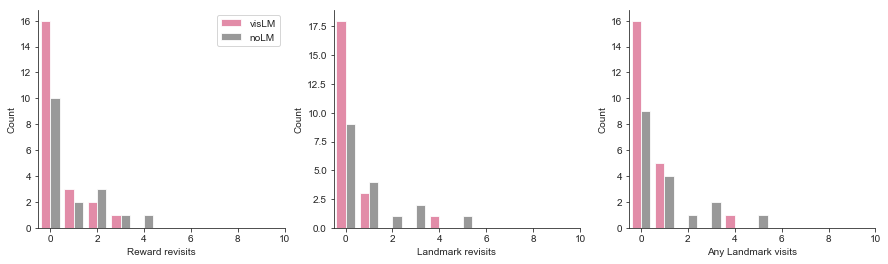

In [68]:
fig, axs = plt.subplots(1,3, figsize=(15,4))

expdatRewRevAll = []
expdatLMRevAll = []
expdatLMVisAll = []

for k, expName in enumerate(expNames):
    n = sampleSizes[k]
    expfile = '{}_{}_revisitsAfterRewardCounts_window_{}s_visitRad{}mm_n{}.npy'.format(genotype,expName,windowMax,visitRad,n)
    expdatRewRev = np.load(summaryDir+ 'revisits'+sep+expfile)
    expdatRewRev = [val for sublist in expdatRewRev for val in sublist]
    expdatRewRevAll.append(expdatRewRev)
    
    expfile = '{}_{}_LMrevisitsAfterRewardCounts_window_{}s_visitRad{}mm_n{}.npy'.format(genotype,expName,windowMax,visitRad,n)
    expdatLMRev = np.load(summaryDir+ 'revisits'+sep+expfile)
    expdatLMRev = [val for sublist in expdatLMRev for val in sublist]
    expdatLMRevAll.append(expdatLMRev)
    
    expfile = '{}_{}_anyLMvisitsAfterRewardCounts_window_{}s_visitRad{}mm_n{}.npy'.format(genotype,expName,windowMax,visitRad,n)
    expdatLMVis = np.load(summaryDir+ 'revisits'+sep+expfile)
    expdatLMVis = [val for sublist in expdatLMVis for val in sublist]
    expdatLMVisAll.append(expdatLMVis)

axs[0].hist(expdatRewRevAll, range=binrange, bins=binrange[1], color=expCols, alpha=0.8, label=expNames, align='left')
axs[0].set_xlabel('Reward revisits')
axs[1].hist(expdatLMRevAll, range=binrange, bins=binrange[1], color=expCols, alpha=0.8, label=expNames, align='left')
axs[1].set_xlabel('Landmark revisits')
axs[2].hist(expdatLMVisAll, range=binrange, bins=binrange[1], color=expCols, alpha=0.8, label=expNames, align='left')
axs[2].set_xlabel('Any Landmark visits')

for i in range(3):
    #axs[i].set_ylim(0,ylims[i])
    axs[i].set_xlim(-0.5,binrange[1])
    axs[i].set_ylabel('Count')
    myAxisTheme(axs[i])
axs[0].legend()

if len(sampleSizes) == 2:
    fig.savefig(summaryDir + 'summary/'+genotype + '_returnsAndLMvisitsPostRewardHistAll_perMeasure_'
                +str(windowMax)+'s_visitRad'+str(visitRad)+'mm_n{}-{}.pdf'.format(sampleSizes[0],sampleSizes[1]), format='pdf')
else:
    fig.savefig(summaryDir + 'summary/'+genotype + '_returnsAndLMvisitsPostRewardHistAll_perMeasure_'
                +str(windowMax)+'s_visitRad'+str(visitRad)+'mm_n{}-{}-{}.pdf'.format(sampleSizes[0],sampleSizes[1],sampleSizes[2]), format='pdf')

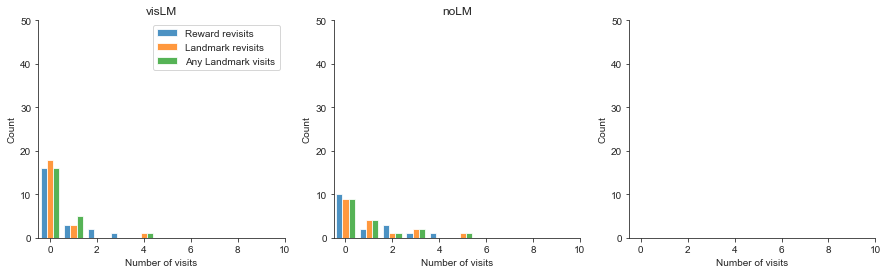

In [71]:
fig, axs = plt.subplots(1,3, figsize=(15,4))

for k, expName in enumerate(expNames):
    expdatAll = []
    n = sampleSizes[k]
    expfile = '{}_{}_revisitsAfterRewardCounts_window_{}s_visitRad{}mm_n{}.npy'.format(genotype,expName,windowMax,visitRad,n)
    expdatRewRev = np.load(summaryDir+ 'revisits'+sep+expfile)
    expdatRewRev = [val for sublist in expdatRewRev for val in sublist]
    expdatAll.append(expdatRewRev)
    
    expfile = '{}_{}_LMrevisitsAfterRewardCounts_window_{}s_visitRad{}mm_n{}.npy'.format(genotype,expName,windowMax,visitRad,n)
    expdatLMRev = np.load(summaryDir+ 'revisits'+sep+expfile)
    expdatLMRev = [val for sublist in expdatLMRev for val in sublist]
    expdatAll.append(expdatLMRev)
    
    expfile = '{}_{}_anyLMvisitsAfterRewardCounts_window_{}s_visitRad{}mm_n{}.npy'.format(genotype,expName,windowMax,visitRad,n)
    expdatLMVis = np.load(summaryDir+ 'revisits'+sep+expfile)
    expdatLMVis = [val for sublist in expdatLMVis for val in sublist]
    expdatAll.append(expdatLMVis)
    
    axs[k].hist(expdatAll, range=binrange, bins=binrange[1], alpha=0.8, label=condNames, align='left')
    axs[k].set_title(expName)

for i in range(3):
    axs[i].set_ylim(0,50)
    axs[i].set_xlim(-0.5,binrange[1])
    axs[i].set_xlabel('Number of visits')
    axs[i].set_ylabel('Count')
    myAxisTheme(axs[i])
axs[0].legend()

if len(sampleSizes) == 2:
    fig.savefig(summaryDir + 'summary/'+genotype + '_returnsAndLMvisitsPostRewardHistAll_perGroup_'
            +str(windowMax)+'s_visitRad'+str(visitRad)+'mm_n{}-{}.pdf'.format(sampleSizes[0],sampleSizes[1]), format='pdf')
else:
    fig.savefig(summaryDir + 'summary/'+genotype + '_returnsAndLMvisitsPostRewardHistAll_perGroup_'
                +str(windowMax)+'s_visitRad'+str(visitRad)+'mm_n{}-{}-{}.pdf'.format(sampleSizes[0],sampleSizes[1],sampleSizes[2]), format='pdf')

#### Per-fly averages

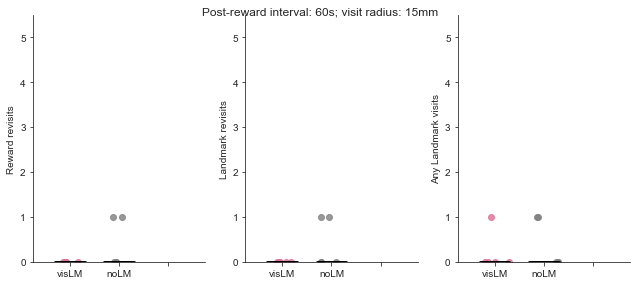

In [77]:
fig, axs = plt.subplots(1,3, figsize=(9,4))
ylims = 5.5

for k, expName in enumerate(expNames):
    expdatRewRevAll = []
    expdatLMRevAll = []
    expdatLMVisAll = []
    n = sampleSizes[k]
    expfile = '{}_{}_revisitsAfterRewardCounts_window_{}s_visitRad{}mm_n{}.npy'.format(genotype,expName,windowMax,visitRad,n)
    expdatRewRev = np.load(summaryDir+ 'revisits'+sep+expfile)
    
    expfile = '{}_{}_LMrevisitsAfterRewardCounts_window_{}s_visitRad{}mm_n{}.npy'.format(genotype,expName,windowMax,visitRad,n)
    expdatLMRev = np.load(summaryDir+ 'revisits'+sep+expfile)
    
    expfile = '{}_{}_anyLMvisitsAfterRewardCounts_window_{}s_visitRad{}mm_n{}.npy'.format(genotype,expName,windowMax,visitRad,n)
    expdatLMVis = np.load(summaryDir+ 'revisits'+sep+expfile)
    
    for fly in range(n):
        if len(expdatRewRev[fly]) > 0: expdatRewRevAll.append(sum(expdatRewRev[fly])/len(expdatRewRev[fly]))
        if len(expdatLMRev[fly]) > 0: expdatLMRevAll.append(sum(expdatLMRev[fly])/len(expdatLMRev[fly]))
        if len(expdatLMVis[fly]) > 0: expdatLMVisAll.append(sum(expdatLMVis[fly])/len(expdatLMVis[fly]))
    
    axs[0].plot(k*np.ones(len(expdatRewRevAll))+0.75+np.random.rand(len(expdatRewRevAll))*.55, expdatRewRevAll,
               'o', color=expCols[k], alpha=0.8)
    axs[1].plot(k*np.ones(len(expdatLMRevAll))+0.75+np.random.rand(len(expdatLMRevAll))*.55, expdatLMRevAll,
               'o', color=expCols[k], alpha=0.8)
    axs[2].plot(k*np.ones(len(expdatLMVisAll))+0.75+np.random.rand(len(expdatLMVisAll))*.55, expdatLMVisAll,
               'o', color=expCols[k], alpha=0.8)
    axs[0].plot([1+k-0.3, 1+k+0.3],[np.median(expdatRewRevAll), np.median(expdatRewRevAll)], color='k', linewidth=3)
    axs[1].plot([1+k-0.3, 1+k+0.3],[np.median(expdatLMRevAll), np.median(expdatLMRevAll)], color='k', linewidth=3)
    axs[2].plot([1+k-0.3, 1+k+0.3],[np.median(expdatLMVisAll), np.median(expdatLMVisAll)], color='k', linewidth=3)
    
    
axs[0].set_ylabel('Reward revisits')
axs[1].set_ylabel('Landmark revisits')
axs[2].set_ylabel('Any Landmark visits')

for i in range(3):
    axs[i].set_xlim(0.25,3.75)
    plt.sca(axs[i])
    plt.xticks(np.arange(3)+1, expNames)
    axs[i].set_ylim(0, ylims)
    myAxisTheme(axs[i])
fig.suptitle('Post-reward interval: {}s; visit radius: {}mm'.format(windowMax,visitRad))
fig.tight_layout()

if len(sampleSizes) == 2:
    fig.savefig(summaryDir + 'summary/'+genotype + '_returnsAndLMvisitsPostRewardHistAll_perFlyAverage'
            +str(windowMax)+'s_visitRad'+str(visitRad)+'mm_n{}-{}.pdf'.format(sampleSizes[0],sampleSizes[1]), format='pdf')
else:
    fig.savefig(summaryDir + 'summary/'+genotype + '_returnsAndLMvisitsPostRewardHistAll_perFlyAverage'
                +str(windowMax)+'s_visitRad'+str(visitRad)+'mm_n{}-{}-{}.pdf'.format(sampleSizes[0],sampleSizes[1],sampleSizes[2]), format='pdf')

#### Total visit count

IOError: [Errno 2] No such file or directory: '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObjOpt/localSearch/Gr64f_x_10xChrimsonR_f/12cmHex/0h/analysis/revisits/Gr64f_x_10xChrimsonR_f_visLM_totalNumberLMVisits_visitRad10mm_n5.npy'

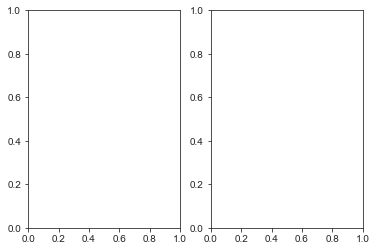

In [86]:
ylims = 70

visRad = [10, 15]
fig, axs = plt.subplots(1,len(visRad), figsize=(3*len(visRad),4))

for k, expName in enumerate(expNames):
    
    for i in range(len(visRad)):
        expdatRewRevAll = []
        expdatLMRevAll = []
        expdatLMVisAll = []
        n = sampleSizes[k]
        expfile = '{}_{}_totalNumberLMVisits_visitRad{}mm_n{}.npy'.format(genotype,expName,visRad[i],n)
        expdatRewRev = np.load(summaryDir+ 'revisits'+sep+expfile)

        axs[i].plot(k*np.ones(len(expdatRewRev))+0.75+np.random.rand(len(expdatRewRev))*.55, expdatRewRev,
                   'o', color=expCols[k], alpha=0.8)
        axs[i].plot([1+k-0.3, 1+k+0.3],[np.median(expdatRewRev), np.median(expdatRewRev)], color='k', linewidth=3)
    
for i in range(len(visRad)):
    axs[i].set_ylabel('count ({}mm)'.format(visRad[i]))

for i in range(3):
    axs[i].set_xlim(0.25,3.75)
    plt.sca(axs[i])
    plt.xticks(np.arange(3)+1, expNames)
    axs[i].set_ylim(0, ylims)
    myAxisTheme(axs[i])
fig.suptitle('Total number of landmark visits')
fig.tight_layout()

if len(sampleSizes) == 2:
    fig.savefig(summaryDir + 'summary/'+genotype + '_totalNumberLMVisits_visitRad'+
            str(visitRad)+'mm_n{}-{}.pdf'.format(sampleSizes[0],sampleSizes[1]), format='pdf')
else:
    fig.savefig(summaryDir + 'summary/'+genotype + '_totalNumberLMVisits_visitRad'+
                str(visitRad)+'mm_n{}-{}-{}.pdf'.format(sampleSizes[0],sampleSizes[1],sampleSizes[2]), format='pdf')

#### Number of distinct landmarks visited

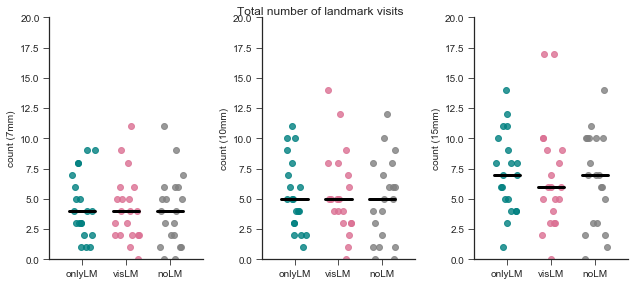

In [64]:
fig, axs = plt.subplots(1,3, figsize=(9,4))
ylims = 20

visRad = [7,10,15]

for k, expName in enumerate(expNames):
    
    for i in range(3):
        expdatRewRevAll = []
        expdatLMRevAll = []
        expdatLMVisAll = []
        n = sampleSizes[k]
        expfile = 'Gr64f-doubleGal4_x_10xChrimsonR_f_{}_totalNumber-Distinct-LMVisits_visitRad{}mm_n{}.npy'.format(expName,visRad[i],n)
        expdat = np.load(summaryDir+'revisits'+sep+expfile)

        axs[i].plot(k*np.ones(len(expdat))+0.75+np.random.rand(len(expdat))*.55, expdat,
                   'o', color=expCols[k], alpha=0.8)
        axs[i].plot([1+k-0.3, 1+k+0.3],[np.median(expdat), np.median(expdat)], color='k', linewidth=3)
    
for i in range(3):
    axs[i].set_ylabel('count ({}mm)'.format(visRad[i]))

for i in range(3):
    axs[i].set_xlim(0.25,3.75)
    plt.sca(axs[i])
    plt.xticks(np.arange(3)+1, expNames)
    axs[i].set_ylim(0, ylims)
    myAxisTheme(axs[i])
fig.suptitle('Total number of landmark visits')
fig.tight_layout()

fig.savefig(summaryDir + 'summaryPlots/'+genotype + '_totalNumber-Distinct-LMVisits_visitRad'+
            str(visitRad)+'mm_n{}-{}-{}.pdf'.format(sampleSizes[0],sampleSizes[1],sampleSizes[2]), format='pdf')

### Intervisit and interreward intervals  --  Need to fix

In [36]:
rewardRad = 10 # mm
visitRad = 15

minutesRange = 5
binRange = (0,minutesRange*60) # start at 1 to exclude counting one reward even twice
numBins = minutesRange*6

IOError: [Errno 2] No such file or directory: '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObjOpto/localSearch/Gr64f-doubleGal4_x_10xChrimsonR/12cmHex/analysis//interVisitInterval/Gr64f-doubleGal4_x_10xChrimsonR_f_onlyLM_interVisitInterval_percentile25-50-75_visitRad15mm_n17.npy'

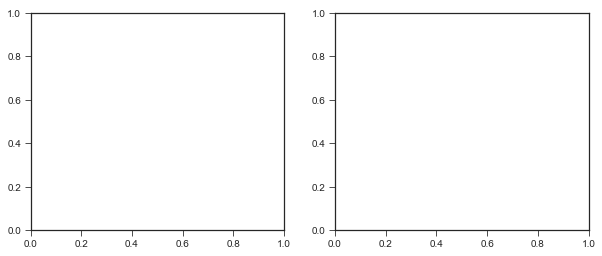

In [38]:
datdir = summaryDir+ '/interVisitInterval'+sep

fig, axs = plt.subplots(1,2,figsize=(10,4))

binRange = (0,minutesRange*60) # start at 1 to exclude counting one reward even twice

for k, expName in enumerate(expNames):
    expfile = 'Gr64f-doubleGal4_x_10xChrimsonR_f_{}_interVisitInterval_percentile25-50-75_visitRad{}mm_n17.npy'.format(expName, str(visitRad))
    expdat = np.load(datdir+expfile)
    
    
    binEds = bin_edges[:-1]+np.diff(bin_edges[:2])/2
    #axs[0].plot(binEds,expdat[1], color=expCols[k], linewidth=2, linestyle='dashed',label='{} median'.format(expName))
    #axs[0].fill_between(binEds,expdat[0], expdat[2], color=expCols[k], linewidth=1, alpha=0.2)
    axs[0].plot(binEds,expdat[3], color=expCols[k], linewidth=2, linestyle='solid', label='{} pooled'.format(expName))

    #axs[1].plot(binEds,np.cumsum(expdat[1]*np.diff(bin_edges)), color=expCols[k], linewidth=2, linestyle='dashed',label='{} median'.format(expName))
    axs[1].plot(binEds,np.cumsum(expdat[3]*np.diff(bin_edges)), color=expCols[k], linewidth=2, linestyle='solid', label='{} pooled'.format(expName))

for ax in axs:
    myAxisTheme(ax)
    ax.legend()
    ax.set_xlabel('Inter-visit-interval [s]')
axs[0].set_ylim(0,0.03)
axs[1].set_ylim(0.5,1)
axs[0].set_ylabel('frequency (normalised per fly')
axs[1].set_ylabel('cummulated frequency (normalised per fly)')

fig.tight_layout()
fig.savefig(summaryDir + 'summaryPlots/'+genotype+'_interVisitIntervalDistr_median-IQR_visitRad'+str(visitRad)+'mm.pdf', format='pdf')

### Inter-reward-interval

IOError: [Errno 2] No such file or directory: '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObjOpto/localSearch/Gr64f-doubleGal4_x_10xChrimsonR/12cmHex/analysis//interVisitInterval/Gr64f-doubleGal4_x_10xChrimsonR_f_onlyLM_interRewardInterval_percentile25-50-75_visitRad15mm_n17.npy'

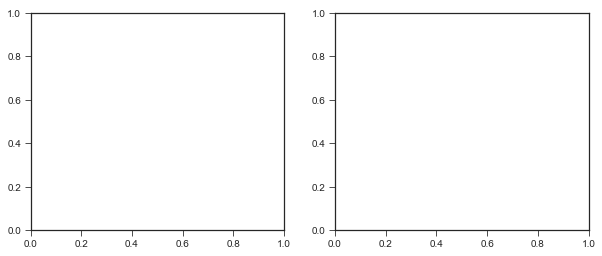

In [39]:
datdir = summaryDir+ '/interVisitInterval'+sep

fig, axs = plt.subplots(1,2,figsize=(10,4))

binRange = (0,minutesRange*60) # start at 1 to exclude counting one reward even twice
numBins = minutesRange*6

visitRad = 15

for k, expName in enumerate(expNames):
    expfile = 'Gr64f-doubleGal4_x_10xChrimsonR_f_{}_interRewardInterval_percentile25-50-75_visitRad{}mm_n17.npy'.format(expName, str(visitRad))
    expdat = np.load(datdir+expfile)
    
    binEds = bin_edges[:-1]+np.diff(bin_edges[:2])/2
    #axs[0].plot(binEds,expdat[1], color=expCols[k], linewidth=2, linestyle='dashed',label='{} median'.format(expName))
    #axs[0].fill_between(binEds,expdat[0], expdat[2], color=expCols[k], linewidth=1, alpha=0.2)
    axs[0].plot(binEds,expdat[3], color=expCols[k], linewidth=2, linestyle='solid', label='{} pooled'.format(expName))

    #axs[1].plot(binEds,np.cumsum(expdat[1]*np.diff(bin_edges)), color=expCols[k], linewidth=2, linestyle='dashed',label='{} median'.format(expName))
    axs[1].plot(binEds,np.cumsum(expdat[3]*np.diff(bin_edges)), color=expCols[k], linewidth=2, linestyle='solid', label='{} pooled'.format(expName))

for ax in axs:
    myAxisTheme(ax)
    ax.legend()
    ax.set_xlabel('Inter-reward-interval [s]')
axs[0].set_ylim(0,0.02)
axs[1].set_ylim(0,1)
axs[0].set_ylabel('frequency (normalised per fly')
axs[1].set_ylabel('cummulated frequency (normalised per fly)')

fig.tight_layout()
fig.savefig(summaryDir + 'summaryPlots/'+genotype+'_interRewardIntervalDistr_median-IQR_visitRad'+str(visitRad)+'mm.pdf', format='pdf')